First, let's permit this notebook to access our Google Drive files. So, we can get our dataset in.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
img_size = (48, 48)
batch_size = 64

validation_path= "/content/test/Facial expression/Datasets/test"
train_path= "/content/test/Facial expression/Datasets/train"

In [ ]:
# Data generator with augmention for training.
data_generator_with_aug = ImageDataGenerator( rescale = 1./255, 
                                             #vertical_flip=True,
                                             horizontal_flip= True)
                                             #rotation_range = 20, 
                                             #shear_range = 0.5, 
                                             #zoom_range = 0.5,
                                             #width_shift_range = 0.5,
                                             #height_shift_range = 0.5,
                                             #fill_mode="constant")

# Read training data.
train = data_generator_with_aug.flow_from_directory( train_path, 
                                                     target_size=img_size, 
                                                     color_mode='grayscale',
                                                     batch_size=batch_size,
                                                     class_mode='categorical') 
                                                    #shuffle=False)

Found 23225 images belonging to 5 classes.


In [ ]:
#Generate data with no augmentation.
data_generator_no_aug = ImageDataGenerator(rescale = 1./255)

#Read validation dataset.
validation = data_generator_no_aug.flow_from_directory(validation_path, 
                                                    target_size= img_size,
                                                    batch_size= batch_size,
                                                    color_mode= 'grayscale',
                                                   class_mode= 'categorical')

Found 3291 images belonging to 5 classes.


For better intution, let's count samples in each class.

In [ ]:
def count_expression(path,Eset):
    dict_count={}
    for expression in os.listdir(path):
        dir= path +'/'+ expression
        dict_count[expression]= len(os.listdir(dir))

    count = pd.DataFrame(dict_count,index=[Eset]).T
    return count

In [ ]:
train_count = count_expression(train_path, 'train')
train_count.T

,angry,surprise,sad,happy,neutral
train,3409,3151,4807,6969,4889


What about testing !

In [ ]:
test_count = count_expression(validation_path, 'test')
test_count.T

,angry,surprise,sad,happy,neutral
test,419,624,620,777,851


For better eye-view, let's visualize this tables with nicer looking bar charts.
<br> But firt, let's set a global style for our graphs.

In [ ]:
sns.set(font_scale=1.7, rc={"figure.figsize":(8,6)})
sns.set_style("ticks")

In [ ]:
def display_percentage(ax, lenght, title):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/int(lenght.sum()))
        x, y= p.get_x() + p.get_width()/4, p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 15, weight="bold")
    sns.despine(trim=True, bottom=True, left=True)
    plt.legend("")
    plt.title(title, weight="bold")

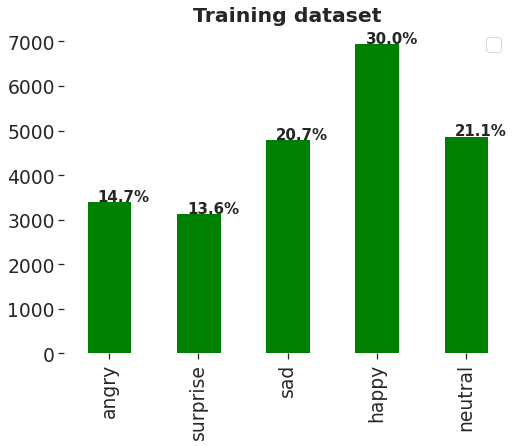

In [ ]:
ax= train_count.plot(kind="bar", color="green")
display_percentage(ax, train_count, "Training dataset")

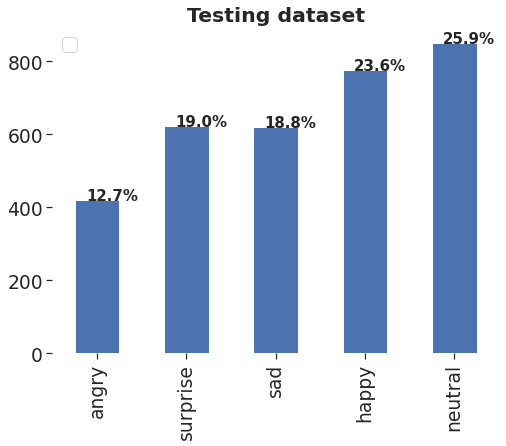

In [ ]:
ax2= test_count.plot(kind="bar")
display_percentage(ax2, test_count, "Testing dataset")

For better intution, let's pick up some random samples from each class.

In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:7]
    plt.figure(figsize=(15, 15))  
    for idx, img_path in enumerate(img_files):
        plt.subplot(7, 7, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()        
        plt.axis('off')
        plt.imshow(img, cmap='gray')

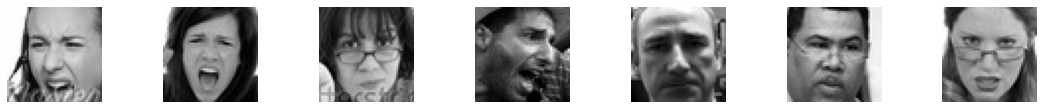

In [ ]:
plot_images(train_path+'/angry')

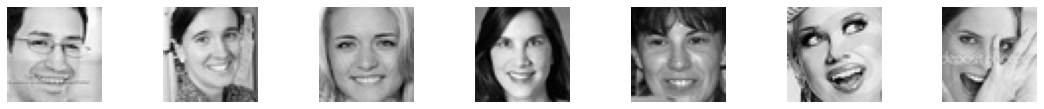

In [ ]:
plot_images(train_path+'/happy')

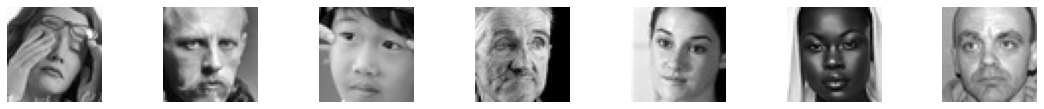

In [ ]:
plot_images(train_path+'/neutral')

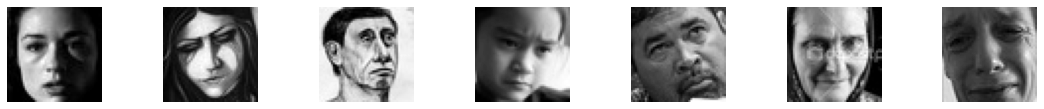

In [ ]:
plot_images(train_path+'/sad')

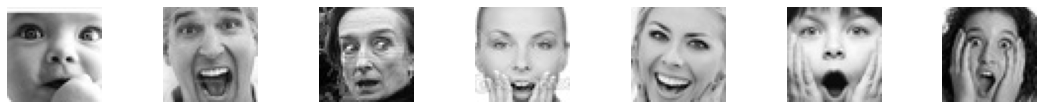

In [ ]:
plot_images(train_path+'/surprise')

Now, Let's build our model.

In [ ]:
# create model structure
model = Sequential()
# Block1
model.add(Conv2D(32, kernel_size=(3, 3), padding="valid", activation='relu', 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(60, kernel_size=(3, 3),  padding="valid", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(250, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(700, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(90, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 60)        17340     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 60)       240       
 hNormalization)                                                 
                                                        

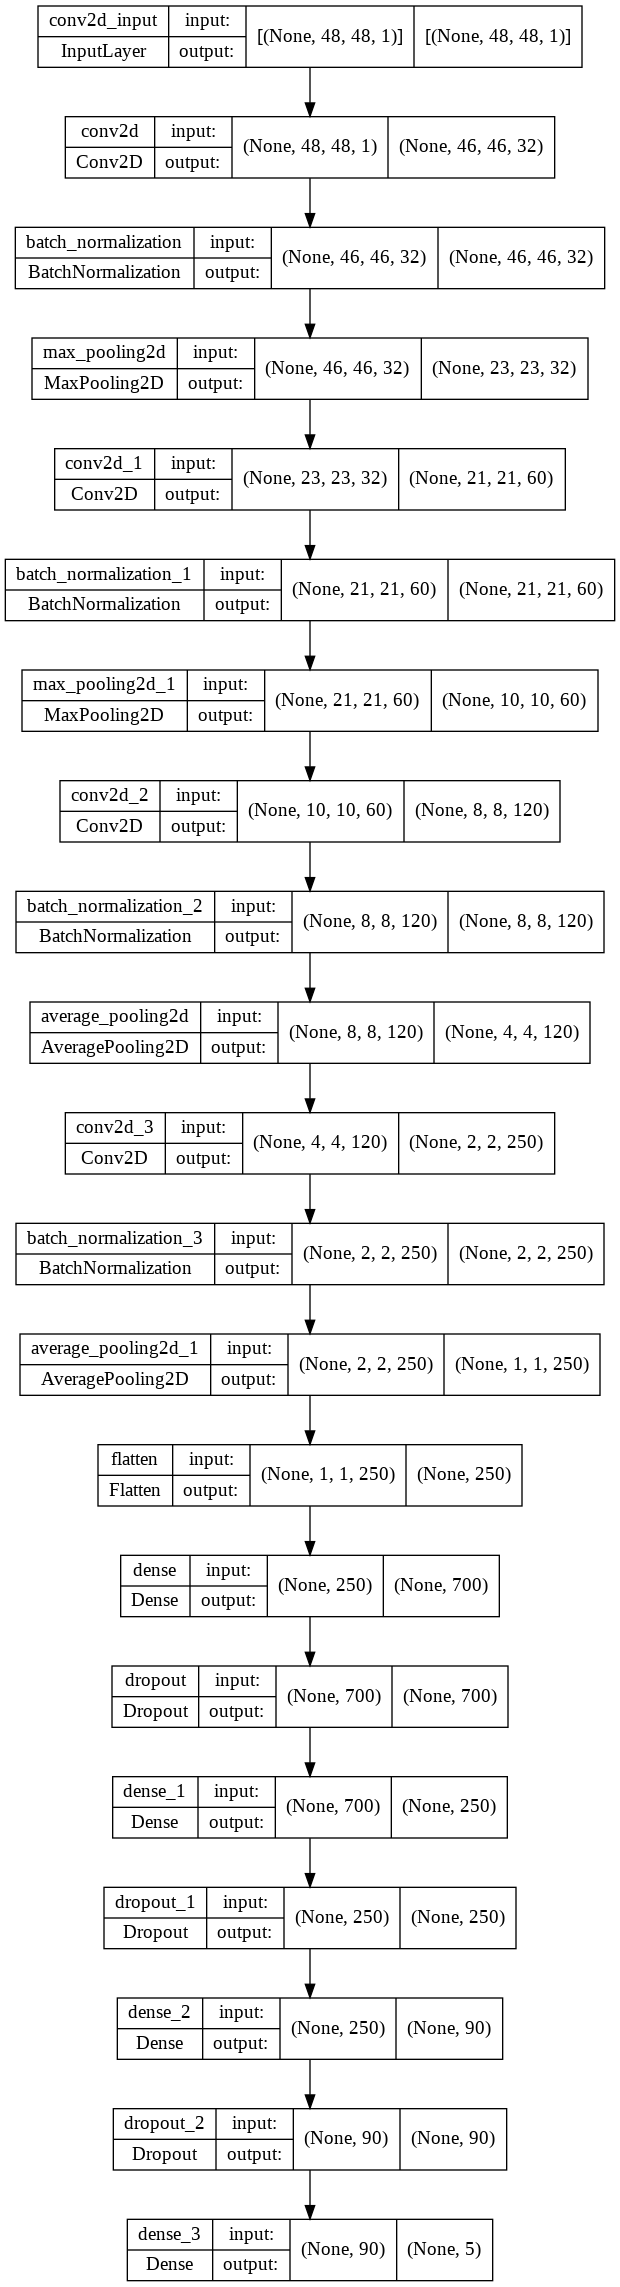

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", 
                      metrics=['accuracy'])

In [ ]:
steps_per_epoch= train.n//train.batch_size
validation_steps = validation.n//validation.batch_size

In [ ]:
model_weights= "/content/test/Facial expression/Datasets/model_weights.h5"

checkpoint = ModelCheckpoint(model_weights, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode='max', patience=10, restore_best_weights=True)
#redlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list = [checkpoint, early]

In [ ]:
history= model.fit( train,
        steps_per_epoch= steps_per_epoch,
        epochs= 50,
        validation_data= validation,
        validation_steps= validation_steps,
        callbacks= callbacks_list)

Epoch 1/50
362/362 [==============================] - ETA: 0s - loss: 1.2605 - accuracy: 0.4817
Epoch 1: val_accuracy improved from -inf to 0.32475, saving model to /content/test/Facial expression/Datasets/model_weights.h5
362/362 [==============================] - 22s 26ms/step - loss: 1.2605 - accuracy: 0.4817 - val_loss: 1.7226 - val_accuracy: 0.3248
Epoch 2/50
361/362 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.6215
Epoch 2: val_accuracy improved from 0.32475 to 0.65196, saving model to /content/test/Facial expression/Datasets/model_weights.h5
362/362 [==============================] - 8s 23ms/step - loss: 0.9794 - accuracy: 0.6218 - val_loss: 0.9552 - val_accuracy: 0.6520
Epoch 3/50
362/362 [==============================] - ETA: 0s - loss: 0.8922 - accuracy: 0.6596
Epoch 3: val_accuracy improved from 0.65196 to 0.73346, saving model to /content/test/Facial expression/Datasets/model_weights.h5
362/362 [==============================] - 8s 23ms/step - lo

Let's evaluate our model performance.

In [ ]:
train_loss, train_accu = model.evaluate(train)
test_loss, test_accu = model.evaluate(validation)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, 
                                                                            test_accu*100))

52/52 [==============================] - 1s 18ms/step - loss: 0.6058 - accuracy: 0.7803
final train accuracy = 80.17 , validation accuracy = 78.03


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


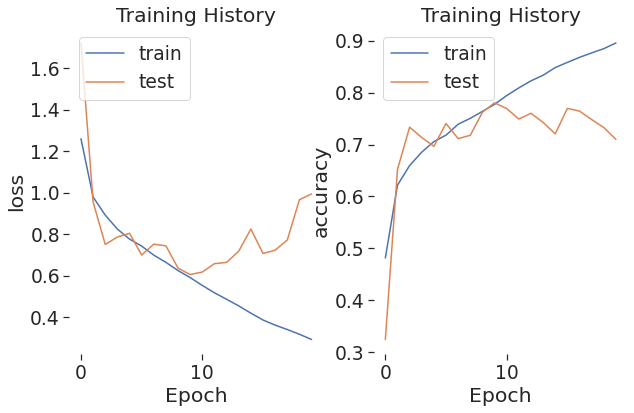

In [ ]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    sns.despine(trim=True, bottom=True, left=True)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
show_train_history(history, 'loss', 'val_loss')
plt.subplot(1, 2, 2)
show_train_history(history, 'accuracy', 'val_accuracy')
plt.show()

In [ ]:
model_json = model.to_json()
with open("/content/test/Facial expression/Datasets/model.json","w") as json_file:
    json_file.write(model_json)

Let's try anther archeticture called ***MobileNetV2***

In [ ]:
from tensorflow.keras.applications import MobileNetV2
baseModel = MobileNetV2(weights= "imagenet", include_top= False, input_shape= (48, 48, 3) )
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
save_weights_path = '/content/test/Facial expression/Datasets/mobile_net_weight.hdf5'

checkpoint = ModelCheckpoint(save_weights_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_freq='epoch')

early = EarlyStopping(monitor="val_accuracy", mode='max', 
                      patience=10, restore_best_weights=True)

redlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)
callbacks_list = [checkpoint, early, redlr]

In [ ]:
history = model.fit( train,
    validation_data=validation,
    epochs = 50,
    callbacks=callbacks_list)

Epoch 1/50
362/363 [============================>.] - ETA: 0s - loss: 1.7117 - accuracy: 0.2809 - auc_1: 0.5907
Epoch 1: val_accuracy improved from -inf to 0.24400, saving model to /content/test/Facial expression/Datasets/mobile_net_weight.hdf5
363/363 [==============================] - 22s 46ms/step - loss: 1.7111 - accuracy: 0.2812 - auc_1: 0.5909 - val_loss: 1.7715 - val_accuracy: 0.2440 - val_auc_1: 0.6242 - lr: 1.0000e-04
Epoch 2/50
362/363 [============================>.] - ETA: 0s - loss: 1.4317 - accuracy: 0.3902 - auc_1: 0.7050
Epoch 2: val_accuracy improved from 0.24400 to 0.38165, saving model to /content/test/Facial expression/Datasets/mobile_net_weight.hdf5
363/363 [==============================] - 15s 41ms/step - loss: 1.4313 - accuracy: 0.3905 - auc_1: 0.7053 - val_loss: 1.4143 - val_accuracy: 0.3816 - val_auc_1: 0.7390 - lr: 1.0000e-04
Epoch 3/50
363/363 [==============================] - ETA: 0s - loss: 1.2931 - accuracy: 0.4707 - auc_1: 0.7721
Epoch 3: val_accuracy i

In [ ]:
train_accu = model.evaluate(train)
test_accu = model.evaluate(validation)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, 
                                                                            test_accu*100))

52/52 [==============================] - 2s 41ms/step - loss: 0.8927 - accuracy: 0.7624 - auc_1: 0.9347


TypeError: ignored

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1', 'lr'])


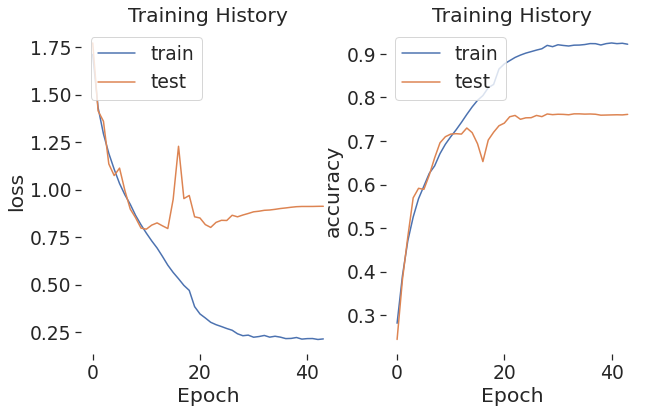

In [ ]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    sns.despine(trim=True, bottom=True, left=True)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
show_train_history(history, 'loss', 'val_loss')
plt.subplot(1, 2, 2)
show_train_history(history, 'accuracy', 'val_accuracy')
plt.show()